In [49]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

import os
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

CSV_DIR = 'csv_merged'

In [50]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [51]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        fillna = lambda v: 0.0 if v == 'nan' else v
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([fillna(row[j][p]) for j in row]) for p in range(batch)]
    return dataf

In [52]:
metrics =  [
    'Model Parameter Randomisation',
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity'    
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x,
    'Faithfulness Correlation': lambda x: x, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    'Selectivity': lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', 'gaussian', 'polycam',
           'cameras']#, 'extremal_perturbation']

models = ['resnet50', 'vgg16']
datasets = ['imagenet']

dico_ranks = {}

In [53]:
# check if recomputed metrics are done
existing_files = set(os.listdir(CSV_DIR))
expected_files = set()

for model in models:
    for dataset in datasets:
        for method in methods:
            for metric in metrics:
                if metric in metrics_with_different_baselines and model == 'resnet50' and method not in ['cameras', 'extremal_perturbation']:
                    for baseline in baselines:
                        expected_files.add(f'{method}_{model}_{dataset}_{metric}_{baseline}.csv')
                else:
                    expected_files.add(f'{method}_{model}_{dataset}_{metric}.csv')

existing_files_but_not_expected = existing_files.difference(expected_files)
expected_files_but_not_existing = expected_files.difference(existing_files)

print(f'EXISTING FILES BUT NOT EXPECTED: {len(existing_files_but_not_expected)}')
for f in sorted(existing_files_but_not_expected):
    print(f)
print()
print(f'EXPECTED FILES BUT NOT EXISTING: {len(expected_files_but_not_existing)}')
for f in sorted(expected_files_but_not_existing):
    print(f)

EXISTING FILES BUT NOT EXPECTED: 247
extremal_perturbation_resnet50_imagenet_Avg-Sensitivity.csv
extremal_perturbation_resnet50_imagenet_Complexity.csv
extremal_perturbation_resnet50_imagenet_EffectiveComplexity.csv
extremal_perturbation_resnet50_imagenet_Faithfulness Correlation.csv
extremal_perturbation_resnet50_imagenet_Faithfulness Estimate.csv
extremal_perturbation_resnet50_imagenet_Local Lipschitz Estimate.csv
extremal_perturbation_resnet50_imagenet_Max-Sensitivity.csv
extremal_perturbation_resnet50_imagenet_Monotonicity Arya.csv
extremal_perturbation_resnet50_imagenet_Monotonicity Nguyen.csv
extremal_perturbation_resnet50_imagenet_Pixel-Flipping.csv
extremal_perturbation_resnet50_imagenet_Random Logit.csv
extremal_perturbation_resnet50_imagenet_Selectivity.csv
extremal_perturbation_resnet50_imagenet_Sparseness.csv
extremal_perturbation_vgg16_imagenet_Complexity.csv
extremal_perturbation_vgg16_imagenet_EffectiveComplexity.csv
extremal_perturbation_vgg16_imagenet_Faithfulness Corr

In [54]:
for dataset in datasets:
    print(f'DATASET {dataset.upper()}')
    dico_ranks[dataset] = {}
    for model in models:
        print(f'MODEL {model.upper()}')
        dico_ranks[dataset][model] = {}
        for metr in metrics:
            if metr in metrics_with_different_baselines and model == 'resnet50':
                for baseline in baselines:
                    data = pd.DataFrame()
                    metr_with_baseline = f'{metr} with {baseline}'
                    print(f"-- Metric: {metr_with_baseline}")
                    for meth in methods:
                        if meth == 'cameras' or meth == 'extremal_perturbation':
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                        else:
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                        df = pd.read_csv(csv_name, header = None)
                        data[meth] = transform[metr](df).values.flatten()
                    ranks = np.array([rankdata(-p) for p in data.values])
                    average_ranks = np.mean(ranks, axis=0)
                    dico_ranks[dataset][model][metr_with_baseline] = average_ranks
            else:
                data = pd.DataFrame()
                print(f"-- Metric: {metr}")
                for meth in methods:
                    csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                    df = pd.read_csv(csv_name, header = None)
                    data[meth] = transform[metr](df).values.flatten()    
                ranks = np.array([rankdata(-p) for p in data.values])
                average_ranks = np.mean(ranks, axis=0)
                dico_ranks[dataset][model][metr] = average_ranks
        print()
    print()
    print()

with open('rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

DATASET IMAGENET
MODEL RESNET50
-- Metric: Model Parameter Randomisation
-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Arya with baseline_black
-- Metric: Monotonicity Arya with baseline_random
-- Metric: M

In [8]:
with open('rankings_by_rank_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [55]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [56]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [57]:
def plot_corr_matrix_figure(dico_ranks, metrics, y_labels, x_labels, filename, fig_size, rotate_x=True, half_rotate_x=False, rotate_y=True, subgroups=None):
    tau_values, p_values = compute_kendall_tau(dico_ranks, metrics)
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(tau_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='viridis')

    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(tau_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='viridis')

    if half_rotate_x:
        plt.xticks(rotation=20, ha="right")
    elif rotate_x:
        plt.xticks(rotation=0)
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='crimson', lw=4, clip_on=False))
            start_i += subgroup_size
    
    plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')
    plt.show()
    plt.close()
    
    print('RESULTS')
    print(f"Kendall's W: {compute_kendall_w(dico_ranks, metrics)}")
    print("Kendall's Tau:")
    for i, metric_a in enumerate(metrics):
        for j, metric_b in enumerate(metrics):
            if i < j:
                print(f'{metric_a} / {metric_b} : {tau_values[i][j]} ({p_values[i][j]})')

In [58]:
def plot_same_baseline_diff_metrics_figure(dico_ranks, baseline, model):   
    selected_metrics = sorted([metric for metric in dico_ranks.keys() if baseline in metric])
    labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
    short_labels = ['FC','FE', 'MA','MN','PF','Se']
    filename = f'final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{baseline}_{model}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

In [59]:
def plot_same_metric_diff_baselines_figure(dico_ranks, metric, model):   
    selected_metrics = sorted([metric_n for metric_n in dico_ranks.keys() if metric in metric_n])
    labels = ['Black (B)', 'Random (R)', 'Uniform (U)', 'White (W)']
    short_labels = ['B','R', 'U','W']
    filename = f'final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{metric}_{model}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(3,2))

# Figures and results for article

## ResNet50

In [60]:
df_ranks = pd.DataFrame(dico_ranks['imagenet']['resnet50'], index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [61]:
df_ranks

,Model Parameter Randomisation,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,Faithfulness Estimate with baseline_white,...,Monotonicity Arya with baseline_white,Complexity,Pixel-Flipping with baseline_black,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white
integratedgrad,3.77450,7.0550,5.3845,6.6770,6.7560,6.9980,9.6890,3.8070,5.8220,8.3650,...,8.26700,2.2935,5.1535,2.9180,3.3685,3.5055,4.3425,5.3190,5.0125,4.6165
smoothgrad,6.96500,5.3210,5.3360,5.1945,5.0365,10.9870,5.9575,6.3770,6.0730,5.5155,...,6.52550,8.1590,6.0460,5.9670,6.6160,5.8130,5.6285,5.9745,5.7660,5.7480
guidedbackprop,8.63050,6.5075,7.1160,7.3735,5.9700,3.6760,6.4780,8.3900,8.2535,9.1365,...,8.82225,1.1170,3.6165,7.2255,4.4720,4.0975,5.4495,6.0440,5.8505,5.6825
rise,4.57950,6.7810,7.4200,7.3695,7.2880,6.1425,6.2750,7.1110,6.8140,6.4230,...,5.56650,11.3755,6.8015,5.9470,6.8505,7.2005,5.9785,6.2810,6.1700,6.1660
gradcam,4.77375,4.9740,5.1010,4.6790,5.1300,6.7745,4.6675,5.5570,5.1435,4.9350,...,5.57675,5.3815,7.6555,6.7350,7.0625,7.9435,8.1800,7.8260,7.9035,8.1330
scorecam,6.80300,5.1060,5.2275,4.7935,5.2045,7.0035,5.3670,6.2540,5.8420,5.5400,...,5.66300,6.9605,7.8250,6.8455,7.2780,8.1755,8.0625,7.7665,7.7800,7.9145
layercam,5.78900,5.0920,5.0085,4.7835,5.2410,9.3125,5.0820,5.9410,5.5600,5.3410,...,6.06900,9.5385,7.7415,6.8980,7.3360,8.1310,8.0265,7.7180,7.8195,8.0325
random,3.74250,9.3160,9.0650,9.3885,9.5625,12.0000,8.1370,7.7540,8.0860,7.6140,...,9.31925,7.4940,4.6540,7.5590,5.9650,3.7890,4.0875,4.9865,4.7900,4.3145
sobel,11.97300,8.7900,9.8840,9.7385,8.7330,1.0000,9.0460,8.5860,8.9320,8.5725,...,5.67675,3.5130,8.1680,9.0215,7.5860,8.1680,6.1620,6.8295,6.6530,6.4555
gaussian,11.02700,6.9855,7.0760,7.1720,7.0370,2.0000,6.3755,7.1045,6.9185,6.1390,...,2.92675,11.3080,7.9725,7.8155,7.9525,8.8260,7.7555,7.0480,7.2520,7.5515


### Faithfulness: same baseline and different metrics

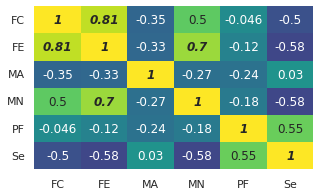

RESULTS
Kendall's W: 0.10110722610722611
Kendall's Tau:
Faithfulness Correlation with baseline_black / Faithfulness Estimate with baseline_black : 0.8091838819320085 (0.0002695626342019211)
Faithfulness Correlation with baseline_black / Monotonicity Arya with baseline_black : -0.3511552695176641 (0.11390323413538203)
Faithfulness Correlation with baseline_black / Monotonicity Nguyen with baseline_black : 0.5038314736557788 (0.023314996382543845)
Faithfulness Correlation with baseline_black / Pixel-Flipping with baseline_black : -0.04580286124143444 (0.8366323297132776)
Faithfulness Correlation with baseline_black / Selectivity with baseline_black : -0.5038314736557788 (0.023314996382543845)
Faithfulness Estimate with baseline_black / Monotonicity Arya with baseline_black : -0.3333333333333333 (0.15259045898802842)
Faithfulness Estimate with baseline_black / Monotonicity Nguyen with baseline_black : 0.6969696969696969 (0.0009744810873283095)
Faithfulness Estimate with baseline_black / P

In [62]:
plot_same_baseline_diff_metrics_figure(dico_ranks['imagenet']['resnet50'], 'baseline_black', 'resnet50')

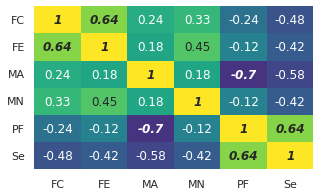

RESULTS
Kendall's W: 0.1351981351981352
Kendall's Tau:
Faithfulness Correlation with baseline_white / Faithfulness Estimate with baseline_white : 0.6363636363636362 (0.003181646992410881)
Faithfulness Correlation with baseline_white / Monotonicity Arya with baseline_white : 0.2424242424242424 (0.3108100139957779)
Faithfulness Correlation with baseline_white / Monotonicity Nguyen with baseline_white : 0.3333333333333333 (0.15259045898802842)
Faithfulness Correlation with baseline_white / Pixel-Flipping with baseline_white : -0.2424242424242424 (0.3108100139957779)
Faithfulness Correlation with baseline_white / Selectivity with baseline_white : -0.4848484848484848 (0.031050242838437284)
Faithfulness Estimate with baseline_white / Monotonicity Arya with baseline_white : 0.1818181818181818 (0.459023957331249)
Faithfulness Estimate with baseline_white / Monotonicity Nguyen with baseline_white : 0.4545454545454545 (0.04473689858238469)
Faithfulness Estimate with baseline_white / Pixel-Flippi

In [63]:
plot_same_baseline_diff_metrics_figure(dico_ranks['imagenet']['resnet50'], 'baseline_white', 'resnet50')

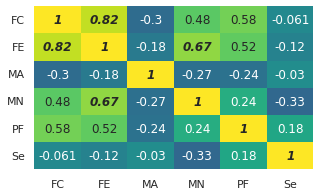

RESULTS
Kendall's W: 0.3076923076923077
Kendall's Tau:
Faithfulness Correlation with baseline_random / Faithfulness Estimate with baseline_random : 0.8181818181818181 (4.4129288920955584e-05)
Faithfulness Correlation with baseline_random / Monotonicity Arya with baseline_random : -0.303030303030303 (0.19694994338223504)
Faithfulness Correlation with baseline_random / Monotonicity Nguyen with baseline_random : 0.4848484848484848 (0.031050242838437284)
Faithfulness Correlation with baseline_random / Pixel-Flipping with baseline_random : 0.5757575757575757 (0.008757732750788306)
Faithfulness Correlation with baseline_random / Selectivity with baseline_random : -0.0606060606060606 (0.8405883696421891)
Faithfulness Estimate with baseline_random / Monotonicity Arya with baseline_random : -0.1818181818181818 (0.459023957331249)
Faithfulness Estimate with baseline_random / Monotonicity Nguyen with baseline_random : 0.6666666666666666 (0.0018032758136924804)
Faithfulness Estimate with baseline_

In [64]:
plot_same_baseline_diff_metrics_figure(dico_ranks['imagenet']['resnet50'], 'baseline_random', 'resnet50')

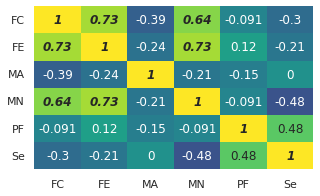

RESULTS
Kendall's W: 0.1926961926961927
Kendall's Tau:
Faithfulness Correlation with baseline_uniform / Faithfulness Estimate with baseline_uniform : 0.7272727272727272 (0.0004988835110362888)
Faithfulness Correlation with baseline_uniform / Monotonicity Arya with baseline_uniform : -0.39393939393939387 (0.0863171145983646)
Faithfulness Correlation with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.6363636363636362 (0.003181646992410881)
Faithfulness Correlation with baseline_uniform / Pixel-Flipping with baseline_uniform : -0.0909090909090909 (0.7373055246579552)
Faithfulness Correlation with baseline_uniform / Selectivity with baseline_uniform : -0.303030303030303 (0.19694994338223504)
Faithfulness Estimate with baseline_uniform / Monotonicity Arya with baseline_uniform : -0.2424242424242424 (0.3108100139957779)
Faithfulness Estimate with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.7272727272727272 (0.0004988835110362888)
Faithfulness Estimate 

In [65]:
plot_same_baseline_diff_metrics_figure(dico_ranks['imagenet']['resnet50'], 'baseline_uniform', 'resnet50')

## Faithfulness: same metric and different baselines

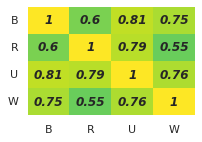

RESULTS
Kendall's W: 0.8446241258741258
Kendall's Tau:
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_random : 0.5954371961386479 (0.007348168541887424)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_uniform : 0.8091838819320085 (0.0002695626342019211)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_white : 0.7481134002767627 (0.0007572036287256326)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_uniform : 0.7878787878787877 (0.00010742344075677409)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_white : 0.5454545454545454 (0.013770768197851531)
Faithfulness Correlation with baseline_uniform / Faithfulness Correlation with baseline_white : 0.7575757575757575 (0.00024002425044091711)


In [66]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Faithfulness Correlation', 'resnet50')

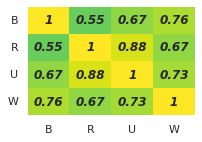

RESULTS
Kendall's W: 0.826048951048951
Kendall's Tau:
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_random : 0.5454545454545454 (0.013770768197851531)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_uniform : 0.6666666666666666 (0.0018032758136924804)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_white : 0.7575757575757575 (0.00024002425044091711)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_uniform : 0.8787878787878787 (5.319397680508792e-06)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_white : 0.6666666666666666 (0.0018032758136924804)
Faithfulness Estimate with baseline_uniform / Faithfulness Estimate with baseline_white : 0.7272727272727272 (0.0004988835110362888)


In [67]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Faithfulness Estimate', 'resnet50')

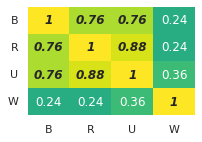

RESULTS
Kendall's W: 0.7001748251748252
Kendall's Tau:
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_random : 0.7575757575757575 (0.00024002425044091711)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_uniform : 0.7575757575757575 (0.00024002425044091711)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_white : 0.2424242424242424 (0.3108100139957779)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_uniform : 0.8787878787878787 (5.319397680508792e-06)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_white : 0.2424242424242424 (0.3108100139957779)
Monotonicity Arya with baseline_uniform / Monotonicity Arya with baseline_white : 0.3636363636363636 (0.11595087782587783)


In [68]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Monotonicity Arya', 'resnet50')

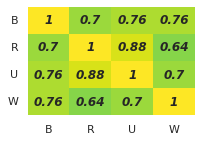

RESULTS
Kendall's W: 0.9195804195804196
Kendall's Tau:
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_random : 0.6969696969696969 (0.0009744810873283095)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_uniform : 0.7575757575757575 (0.00024002425044091711)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_white : 0.7575757575757575 (0.00024002425044091711)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_uniform : 0.8787878787878787 (5.319397680508792e-06)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_white : 0.6363636363636362 (0.003181646992410881)
Monotonicity Nguyen with baseline_uniform / Monotonicity Nguyen with baseline_white : 0.6969696969696969 (0.0009744810873283095)


In [69]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Monotonicity Nguyen', 'resnet50')

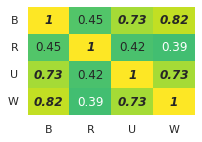

RESULTS
Kendall's W: 0.7613636363636364
Kendall's Tau:
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_random : 0.4545454545454545 (0.04473689858238469)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_uniform : 0.7272727272727272 (0.0004988835110362888)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_white : 0.8181818181818181 (4.4129288920955584e-05)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_uniform : 0.4242424242424242 (0.06286914699241088)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_white : 0.39393939393939387 (0.0863171145983646)
Pixel-Flipping with baseline_uniform / Pixel-Flipping with baseline_white : 0.7272727272727272 (0.0004988835110362888)


In [70]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Pixel-Flipping', 'resnet50')

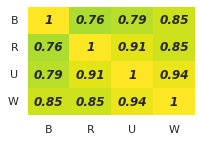

RESULTS
Kendall's W: 0.9475524475524476
Kendall's Tau:
Selectivity with baseline_black / Selectivity with baseline_random : 0.7575757575757575 (0.00024002425044091711)
Selectivity with baseline_black / Selectivity with baseline_uniform : 0.7878787878787877 (0.00010742344075677409)
Selectivity with baseline_black / Selectivity with baseline_white : 0.8484848484848484 (1.6342325370103148e-05)
Selectivity with baseline_random / Selectivity with baseline_uniform : 0.909090909090909 (1.4655483405483405e-06)
Selectivity with baseline_random / Selectivity with baseline_white : 0.8484848484848484 (1.6342325370103148e-05)
Selectivity with baseline_uniform / Selectivity with baseline_white : 0.9393939393939392 (3.2150205761316875e-07)


In [71]:
plot_same_metric_diff_baselines_figure(dico_ranks['imagenet']['resnet50'], 'Selectivity', 'resnet50')

### Complexity

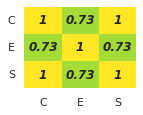

RESULTS
Kendall's W: 0.9362859362859363
Kendall's Tau:
Complexity / EffectiveComplexity : 0.7288792981454687 (0.0011497640731724446)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
EffectiveComplexity / Sparseness : 0.7288792981454687 (0.0011497640731724446)


In [72]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_complexity_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

### Randomization

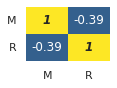

RESULTS
Kendall's W: 0.28321678321678323
Kendall's Tau:
Model Parameter Randomisation / Random Logit : -0.39393939393939387 (0.0863171145983646)


In [73]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_randomization_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(1.5,1))

## Robustness

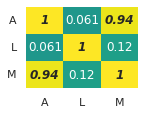

RESULTS
Kendall's W: 0.6161616161616161
Kendall's Tau:
Avg-Sensitivity / Local Lipschitz Estimate : 0.0606060606060606 (0.8405883696421891)
Avg-Sensitivity / Max-Sensitivity : 0.9393939393939392 (3.2150205761316875e-07)
Local Lipschitz Estimate / Max-Sensitivity : 0.1212121212121212 (0.6383612539081289)


In [74]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_robustness_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics with default baselines (i.e. black)

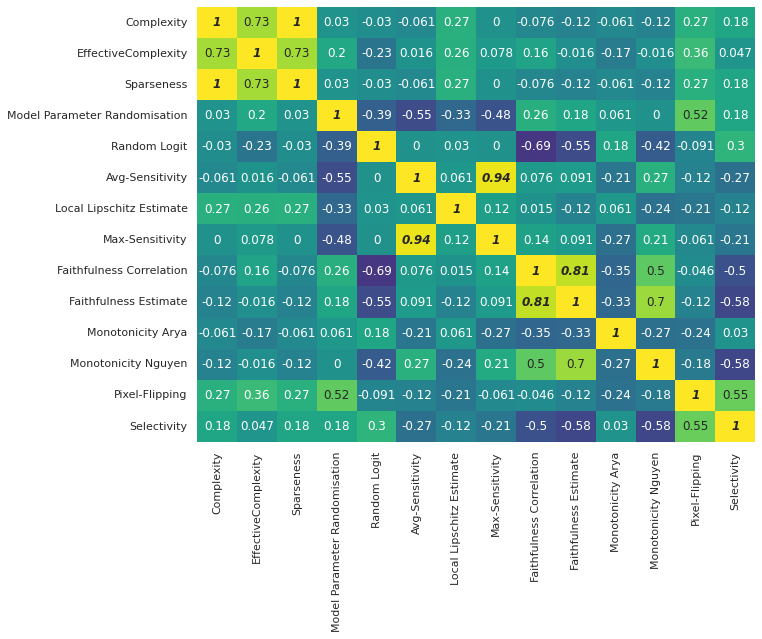

RESULTS
Kendall's W: 0.07975952618809762
Kendall's Tau:
Complexity / EffectiveComplexity : 0.7288792981454687 (0.0011497640731724446)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
Complexity / Model Parameter Randomisation : 0.0303030303030303 (0.9465592891547753)
Complexity / Random Logit : -0.0303030303030303 (0.9465592891547753)
Complexity / Avg-Sensitivity : -0.0606060606060606 (0.8405883696421891)
Complexity / Local Lipschitz Estimate : 0.2727272727272727 (0.24957952123750735)
Complexity / Max-Sensitivity : 0.0 (1.0534407108452248)
Complexity / Faithfulness Correlation with baseline_black : -0.0763381020690574 (0.7310931976144447)
Complexity / Faithfulness Estimate with baseline_black : -0.1212121212121212 (0.6383612539081289)
Complexity / Monotonicity Arya with baseline_black : -0.0606060606060606 (0.8405883696421891)
Complexity / Monotonicity Nguyen with baseline_black : -0.1212121212121212 (0.6383612539081289)
Complexity / Pixel-Flipping with baseline_blac

In [75]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation with baseline_black',
    'Faithfulness Estimate with baseline_black',
    'Monotonicity Arya with baseline_black',
    'Monotonicity Nguyen with baseline_black',
    'Pixel-Flipping with baseline_black',
    'Selectivity with baseline_black'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False)

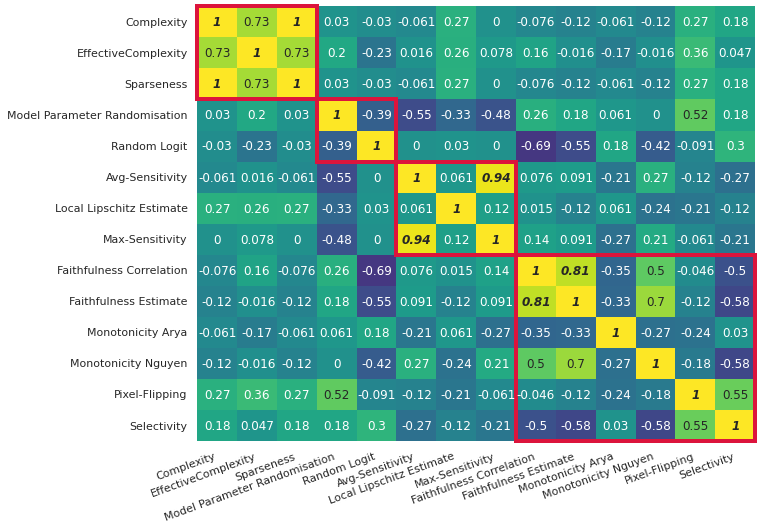

RESULTS
Kendall's W: 0.07975952618809762
Kendall's Tau:
Complexity / EffectiveComplexity : 0.7288792981454687 (0.0011497640731724446)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
Complexity / Model Parameter Randomisation : 0.0303030303030303 (0.9465592891547753)
Complexity / Random Logit : -0.0303030303030303 (0.9465592891547753)
Complexity / Avg-Sensitivity : -0.0606060606060606 (0.8405883696421891)
Complexity / Local Lipschitz Estimate : 0.2727272727272727 (0.24957952123750735)
Complexity / Max-Sensitivity : 0.0 (1.0534407108452248)
Complexity / Faithfulness Correlation with baseline_black : -0.0763381020690574 (0.7310931976144447)
Complexity / Faithfulness Estimate with baseline_black : -0.1212121212121212 (0.6383612539081289)
Complexity / Monotonicity Arya with baseline_black : -0.0606060606060606 (0.8405883696421891)
Complexity / Monotonicity Nguyen with baseline_black : -0.1212121212121212 (0.6383612539081289)
Complexity / Pixel-Flipping with baseline_blac

In [76]:
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, labels, labels, filename, fig_size=(10,8), half_rotate_x=True, subgroups=(3,2,3,6))

### All metrics with all baselines

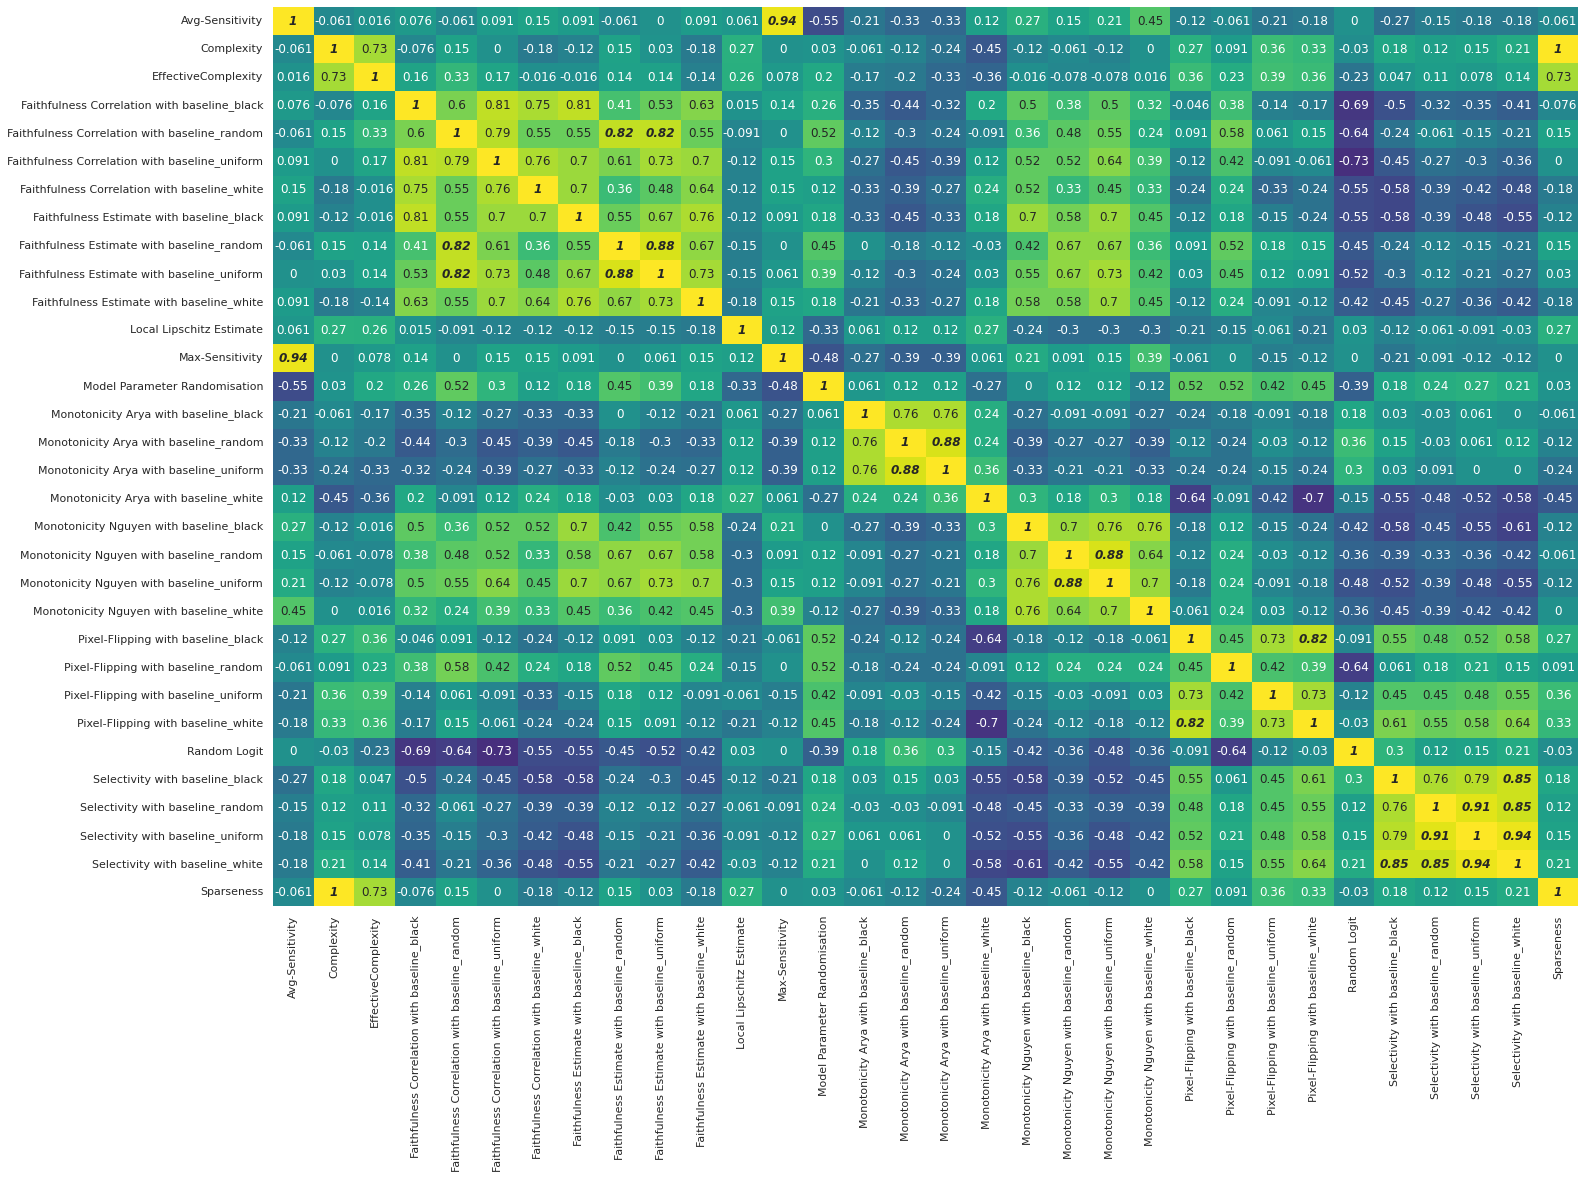

RESULTS
Kendall's W: 0.08877499453671328
Kendall's Tau:
Avg-Sensitivity / Complexity : -0.0606060606060606 (0.8405883696421891)
Avg-Sensitivity / EffectiveComplexity : 0.015508070173307846 (0.944853151135727)
Avg-Sensitivity / Faithfulness Correlation with baseline_black : 0.0763381020690574 (0.7310931976144447)
Avg-Sensitivity / Faithfulness Correlation with baseline_random : -0.0606060606060606 (0.8405883696421891)
Avg-Sensitivity / Faithfulness Correlation with baseline_uniform : 0.0909090909090909 (0.7373055246579552)
Avg-Sensitivity / Faithfulness Correlation with baseline_white : 0.1515151515151515 (0.5452047007776174)
Avg-Sensitivity / Faithfulness Estimate with baseline_black : 0.0909090909090909 (0.7373055246579552)
Avg-Sensitivity / Faithfulness Estimate with baseline_random : -0.0606060606060606 (0.8405883696421891)
Avg-Sensitivity / Faithfulness Estimate with baseline_uniform : 0.0 (1.0534407108452248)
Avg-Sensitivity / Faithfulness Estimate with baseline_white : 0.09090909

In [78]:
selected_metrics = sorted(dico_ranks['imagenet']['resnet50'].keys())
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_all_baselines_resnet50'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, selected_metrics, selected_metrics, filename, fig_size=(23.4,16.54), rotate_x=False)

## VGG16

In [79]:
df_ranks = pd.DataFrame(dico_ranks['imagenet']['vgg16'], index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [80]:
df_ranks

,Model Parameter Randomisation,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Random Logit,Max-Sensitivity,Sparseness,EffectiveComplexity,Monotonicity Arya,Complexity,Pixel-Flipping,Selectivity
integratedgrad,4.1230,5.9390,5.8910,8.8425,7.2710,3.0070,9.01000,3.0050,3.9810,5.00950,6.29325,3.9475,7.2345,6.4825
smoothgrad,7.8320,4.9945,10.9075,6.9745,6.9195,2.0000,7.01300,2.0000,10.0810,9.45775,6.73825,10.1010,6.7350,6.6950
guidedbackprop,9.8625,7.4770,3.3490,6.8260,6.6945,4.2525,4.00100,4.1485,2.4270,3.62925,6.25425,2.2735,6.7230,6.6790
rise,4.6220,7.8170,6.7745,6.3985,6.0945,5.4590,10.78100,5.5185,10.8015,9.02375,6.58750,10.7535,4.9560,6.1370
gradcam,4.3250,6.0895,9.0745,4.4850,5.3800,9.5180,11.01950,9.7920,2.8350,1.99275,6.61225,2.9470,5.8180,6.2665
scorecam,5.9860,5.3920,5.8140,6.7510,6.8270,7.3080,5.08500,7.4115,8.0080,9.45600,6.37725,8.0880,7.0290,6.6835
layercam,5.3550,5.0910,9.4805,5.6960,6.1860,9.0070,8.51850,8.8845,7.7765,9.45775,6.54925,7.8730,6.6885,6.4305
random,4.1320,8.2875,12.0000,6.8840,6.7740,12.0000,2.19225,12.0000,8.3575,8.11850,6.29050,8.1940,6.8770,6.5715
sobel,11.0000,9.6525,2.0000,6.9035,6.8150,10.9770,1.61550,10.8665,4.9415,7.20550,6.54750,4.9415,6.7645,6.7750
gaussian,12.0000,7.3425,1.0000,6.6930,6.8095,1.0000,2.19225,1.0000,11.5055,9.45775,6.73825,11.5275,6.8125,6.6100


### Faithfulness with black baseline and different metrics

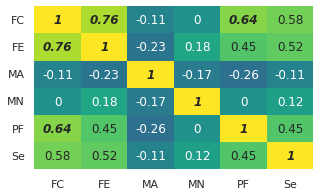

RESULTS
Kendall's W: 0.3722804972804973
Kendall's Tau:
Faithfulness Correlation / Faithfulness Estimate : 0.7575757575757575 (0.00024002425044091711)
Faithfulness Correlation / Monotonicity Arya : -0.10687334289668038 (0.6304167324095719)
Faithfulness Correlation / Monotonicity Nguyen : 0.0 (1.0534407108452248)
Faithfulness Correlation / Pixel-Flipping : 0.6363636363636362 (0.003181646992410881)
Faithfulness Correlation / Selectivity : 0.5757575757575757 (0.008757732750788306)
Faithfulness Estimate / Monotonicity Arya : -0.22901430620717222 (0.3025337411745722)
Faithfulness Estimate / Monotonicity Nguyen : 0.1818181818181818 (0.459023957331249)
Faithfulness Estimate / Pixel-Flipping : 0.4545454545454545 (0.04473689858238469)
Faithfulness Estimate / Selectivity : 0.5151515151515151 (0.020980351631393297)
Monotonicity Arya / Monotonicity Nguyen : -0.1679438245519263 (0.4496025895128465)
Monotonicity Arya / Pixel-Flipping : -0.2595495470347952 (0.24261168044983128)
Monotonicity Arya / Sel

In [81]:
selected_metrics = ['Faithfulness Correlation','Faithfulness Estimate','Monotonicity Arya','Monotonicity Nguyen','Pixel-Flipping','Selectivity']
labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
short_labels = ['FC','FE', 'MA','MN','PF','Se']
filename = 'rebuttal_final_corr_matrix_rank_aggreg_holm_corr_faithfulness_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

### Complexity

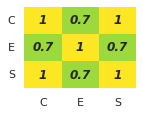

RESULTS
Kendall's W: 0.9331779331779332
Kendall's Tau:
Complexity / EffectiveComplexity : 0.697863157798853 (0.0018537488077340115)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
EffectiveComplexity / Sparseness : 0.6978631577988531 (0.0018537488077340115)


In [82]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_complexity_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

### Randomization

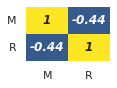

RESULTS
Kendall's W: 0.2229020979020979
Kendall's Tau:
Model Parameter Randomisation / Random Logit : -0.442760992000533 (0.04622906055239077)


In [83]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_randomization_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, short_labels, short_labels, filename, fig_size=(1.5,1))

## Robustness

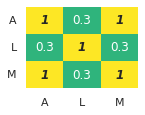

RESULTS
Kendall's W: 0.710955710955711
Kendall's Tau:
Avg-Sensitivity / Local Lipschitz Estimate : 0.303030303030303 (0.19694994338223504)
Avg-Sensitivity / Max-Sensitivity : 0.9999999999999998 (4.17535139757362e-09)
Local Lipschitz Estimate / Max-Sensitivity : 0.303030303030303 (0.19694994338223504)


In [84]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_robustness_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics with default baselines (i.e. black)

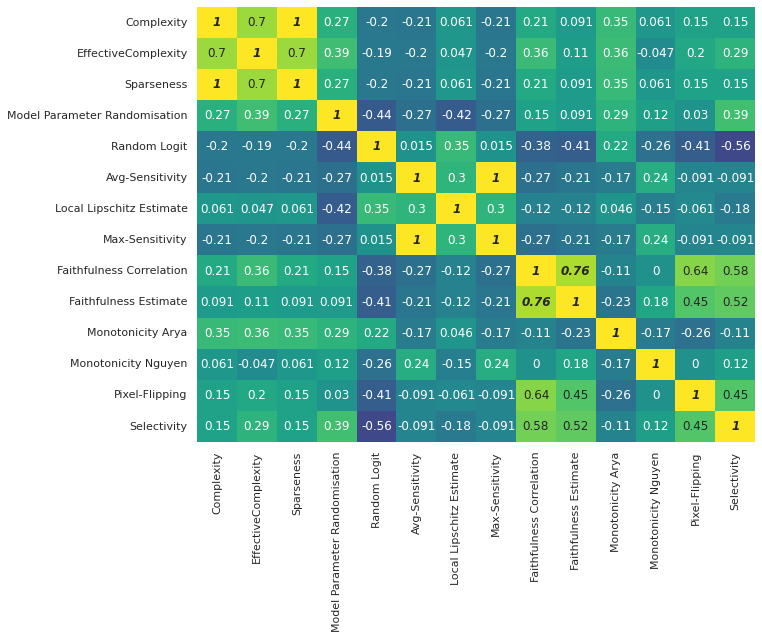

RESULTS
Kendall's W: 0.13424075924075923
Kendall's Tau:
Complexity / EffectiveComplexity : 0.697863157798853 (0.0018537488077340115)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
Complexity / Model Parameter Randomisation : 0.2727272727272727 (0.24957952123750735)
Complexity / Random Logit : -0.19847906537954926 (0.37156462722472616)
Complexity / Avg-Sensitivity : -0.2121212121212121 (0.38070480349126185)
Complexity / Local Lipschitz Estimate : 0.0606060606060606 (0.8405883696421891)
Complexity / Max-Sensitivity : -0.2121212121212121 (0.38070480349126185)
Complexity / Faithfulness Correlation : 0.2121212121212121 (0.38070480349126185)
Complexity / Faithfulness Estimate : 0.0909090909090909 (0.7373055246579552)
Complexity / Monotonicity Arya : 0.3511552695176641 (0.11390323413538203)
Complexity / Monotonicity Nguyen : 0.0606060606060606 (0.8405883696421891)
Complexity / Pixel-Flipping : 0.1515151515151515 (0.5452047007776174)
Complexity / Selectivity : 0.1515151515

In [85]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False)

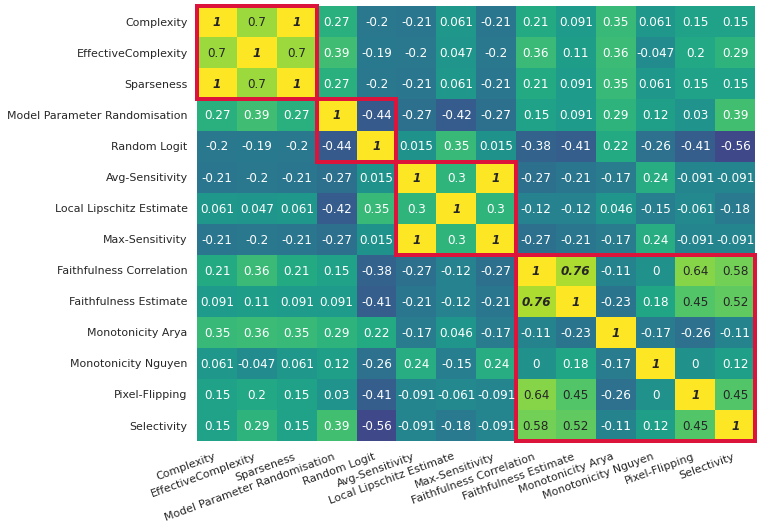

RESULTS
Kendall's W: 0.13424075924075923
Kendall's Tau:
Complexity / EffectiveComplexity : 0.697863157798853 (0.0018537488077340115)
Complexity / Sparseness : 0.9999999999999998 (4.17535139757362e-09)
Complexity / Model Parameter Randomisation : 0.2727272727272727 (0.24957952123750735)
Complexity / Random Logit : -0.19847906537954926 (0.37156462722472616)
Complexity / Avg-Sensitivity : -0.2121212121212121 (0.38070480349126185)
Complexity / Local Lipschitz Estimate : 0.0606060606060606 (0.8405883696421891)
Complexity / Max-Sensitivity : -0.2121212121212121 (0.38070480349126185)
Complexity / Faithfulness Correlation : 0.2121212121212121 (0.38070480349126185)
Complexity / Faithfulness Estimate : 0.0909090909090909 (0.7373055246579552)
Complexity / Monotonicity Arya : 0.3511552695176641 (0.11390323413538203)
Complexity / Monotonicity Nguyen : 0.0606060606060606 (0.8405883696421891)
Complexity / Pixel-Flipping : 0.1515151515151515 (0.5452047007776174)
Complexity / Selectivity : 0.1515151515

In [86]:
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, labels, labels, filename, fig_size=(10,8), half_rotate_x=True, subgroups=(3,2,3,6))

### All metrics with all baselines

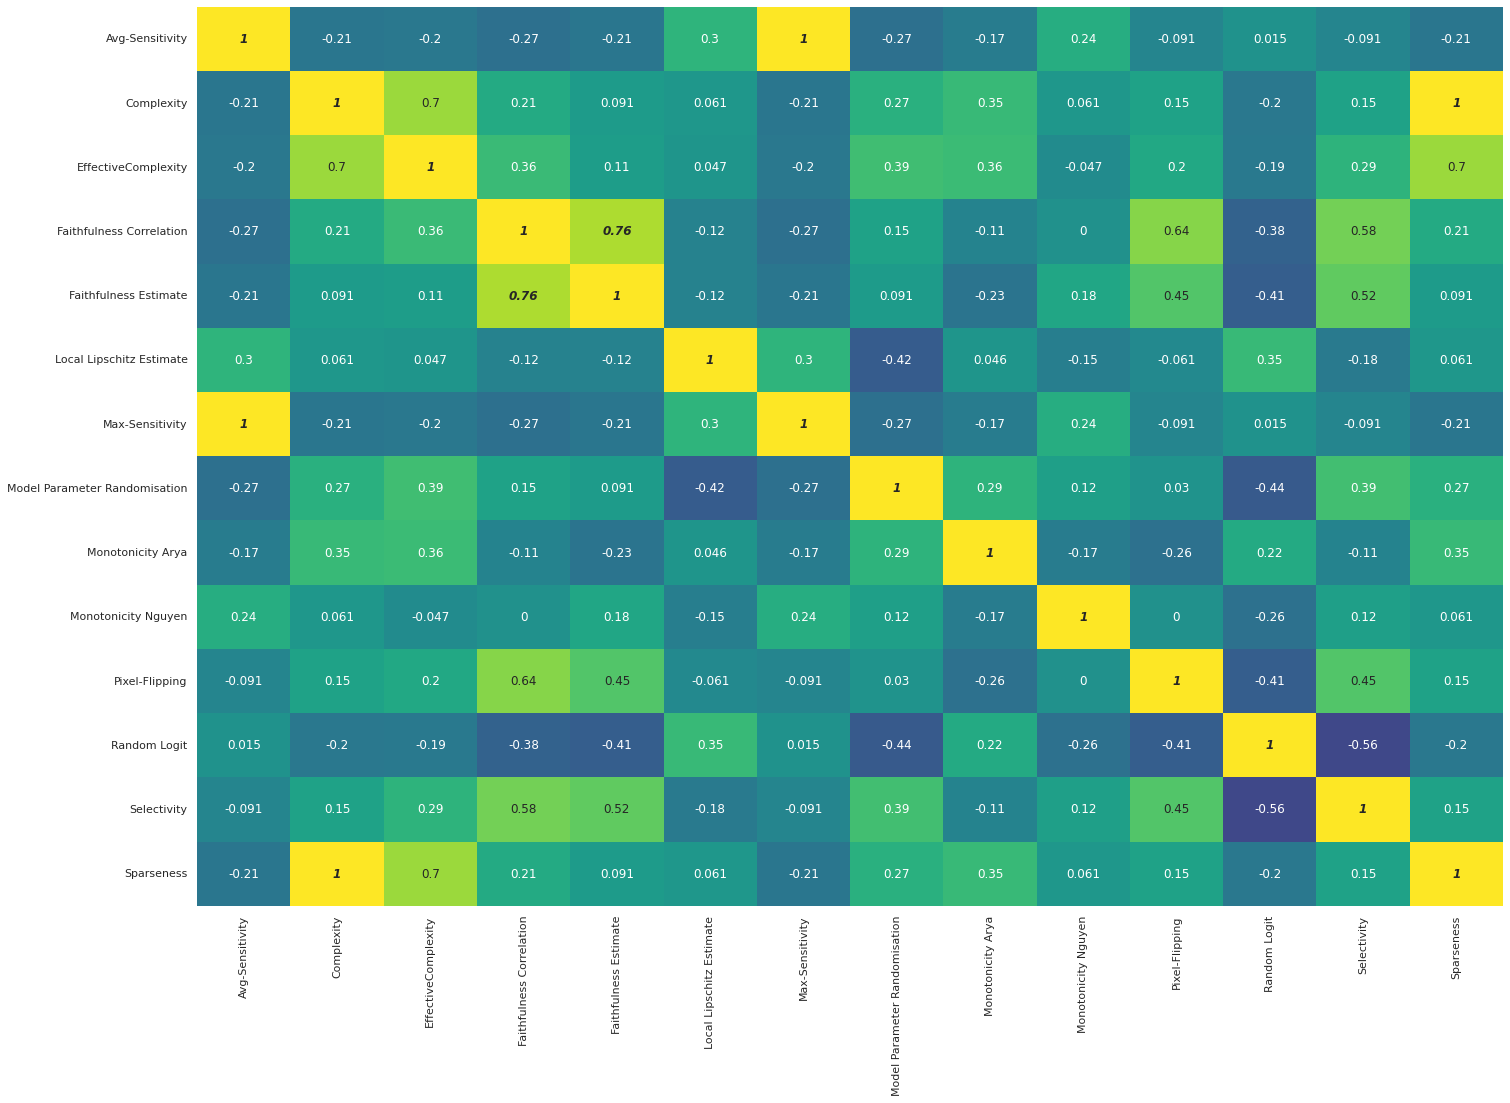

RESULTS
Kendall's W: 0.13424075924075923
Kendall's Tau:
Avg-Sensitivity / Complexity : -0.2121212121212121 (0.38070480349126185)
Avg-Sensitivity / EffectiveComplexity : -0.201604912253002 (0.368530801392455)
Avg-Sensitivity / Faithfulness Correlation : -0.2727272727272727 (0.24957952123750735)
Avg-Sensitivity / Faithfulness Estimate : -0.2121212121212121 (0.38070480349126185)
Avg-Sensitivity / Local Lipschitz Estimate : 0.303030303030303 (0.19694994338223504)
Avg-Sensitivity / Max-Sensitivity : 0.9999999999999998 (4.17535139757362e-09)
Avg-Sensitivity / Model Parameter Randomisation : -0.2727272727272727 (0.24957952123750735)
Avg-Sensitivity / Monotonicity Arya : -0.1679438245519263 (0.4496025895128465)
Avg-Sensitivity / Monotonicity Nguyen : 0.2424242424242424 (0.3108100139957779)
Avg-Sensitivity / Pixel-Flipping : -0.0909090909090909 (0.7373055246579552)
Avg-Sensitivity / Random Logit : 0.015267620413811482 (0.9452010837327357)
Avg-Sensitivity / Selectivity : -0.0909090909090909 (0.7

In [88]:
selected_metrics = sorted(dico_ranks['imagenet']['vgg16'].keys())
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_all_baselines_vgg16'
plot_corr_matrix_figure(dico_ranks['imagenet']['vgg16'], selected_metrics, selected_metrics, selected_metrics, filename, fig_size=(23.4,16.54), rotate_x=False)